In [ ]:
!pip install -q -U "datasets==2.16.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
import json
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from sklearn.model_selection import train_test_split
from datasets import Dataset
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["0", "1"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the JSON data from the file
# with open('/content/drive/MyDrive/DiversevulDataSet/diversevul_20230702.json', 'r') as f:
#     json_data = f.readlines()

with open('/content/drive/MyDrive/llama/data/diversevul_20230702.json', 'r') as f:
    json_data = f.readlines()

# Parse each JSON object in the file
data_list = [json.loads(json_str) for json_str in json_data]

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)

# Print the head of the DataFrame
df.head()

,func,target,cwe,project,commit_id,hash,size,message
0,int _gnutls_ciphertext2compressed(gnutls_sessi...,1,[],gnutls,7ad6162573ba79a4392c63b453ad0220ca6c5ace,73008646937836648589283922871188272089,157,added an extra check while checking the padding.
1,static char *make_filename_safe(const char *fi...,1,[CWE-264],php-src,055ecbc62878e86287d742c7246c21606cee8183,211824207069112513181516095447837228041,22,Improve check for :memory: pseudo-filename in ...
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...",1,[],busybox,251fc70e9722f931eec23a34030d05ba5f747b0e,21401706257394042943815500829552774160,232,uncompress: fix buffer underrun by corrupted i...
3,"static void cirrus_do_copy(CirrusVGAState *s, ...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,135590882627853658533498335902319684573,66,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...",1,[CWE-787],qemu,b2eb849d4b1fdb6f35d5c46958c7f703cf64cfef,27696392987383562433164405181263025184,18,"CVE-2007-1320 - Cirrus LGD-54XX ""bitblt"" heap ..."


In [ ]:
a=df['func']
df.isnull().sum()
# b= df['target'].map({0: '0', 1: '1'})
if 'target' in df.columns:
    b=df['target'].map({0: '0', 1: '1'})
else:
     print("The 'target' column does not exist in the DataFrame.")

df= pd.concat([a,b], axis=1)
df.rename(columns={'target' : 'label'},
                    inplace=True)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)
df

,func,label
0,int _gnutls_ciphertext2compressed(gnutls_sessi...,1
1,static char *make_filename_safe(const char *fi...,1
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...",1
3,"static void cirrus_do_copy(CirrusVGAState *s, ...",1
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...",1
...,...,...
330487,CpuDefinitionInfoList *qmp_query_cpu_definitio...,0
330488,static bool loongarch_cpu_exec_interrupt(CPUSt...,0
330489,static bool loongarch_cpu_has_work(CPUState *c...,0
330490,static void loongarch_cpu_add_definition(gpoin...,0


In [ ]:
df.isnull().values.any()

False

In [ ]:
#Create independent and Dependent Features
columns = df.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["label"]]
# Store the variable we are predicting
target = "label"
# Define a random state
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(330492, 1)
(330492,)


In [ ]:
print(X)

                                                     func
0       int _gnutls_ciphertext2compressed(gnutls_sessi...
1       static char *make_filename_safe(const char *fi...
2       unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...
3       static void cirrus_do_copy(CirrusVGAState *s, ...
4       glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...
...                                                   ...
330487  CpuDefinitionInfoList *qmp_query_cpu_definitio...
330488  static bool loongarch_cpu_exec_interrupt(CPUSt...
330489  static bool loongarch_cpu_has_work(CPUState *c...
330490  static void loongarch_cpu_add_definition(gpoin...
330491  static void loongarch_cpu_synchronize_from_tb(...

[330492 rows x 1 columns]


Text(0, 0.5, 'Frequency')

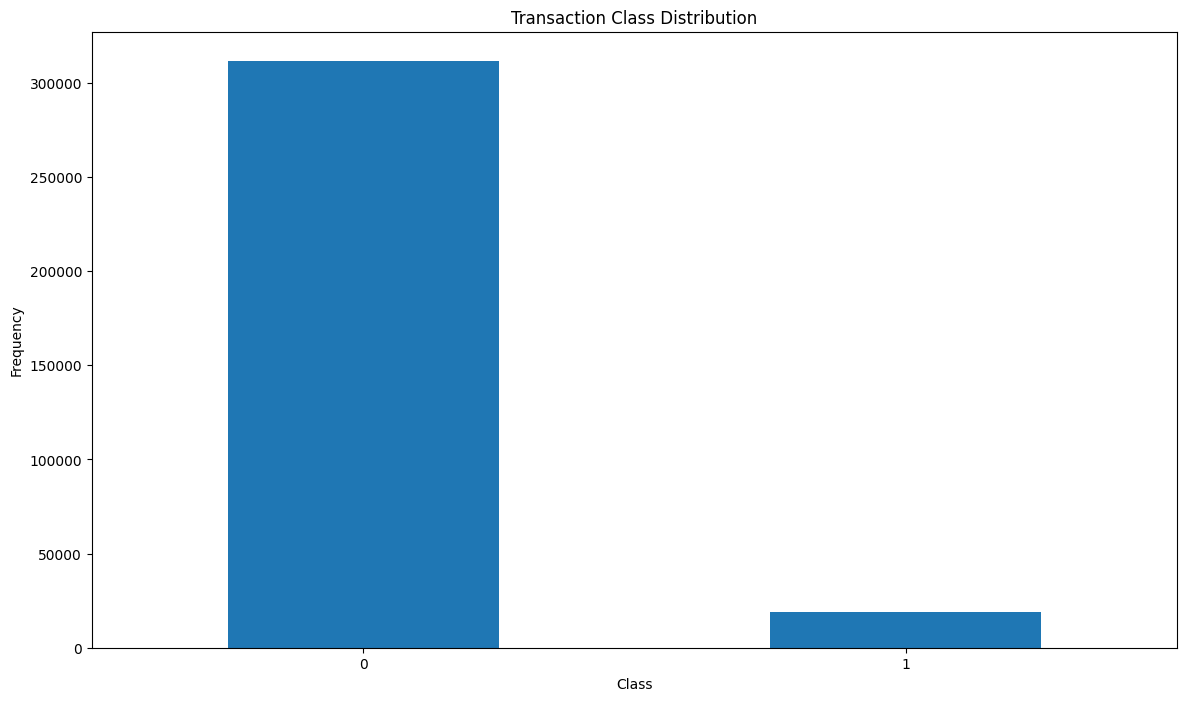

In [ ]:
count_classes = pd.value_counts(df['label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [ ]:
## Get the vulnerable and the non-vulnerable dataset

vulnerable = df[df['label']==1]

nonvulnerable = df[df['label']==0]

In [ ]:
print(vulnerable.shape,nonvulnerable.shape)

(18945, 2) (311547, 2)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Implementing Undersampling for Handling Imbalanced
rus = RandomUnderSampler(sampling_strategy=1)
X_res,y_res=rus.fit_resample(X,Y)

In [ ]:
X_res.shape,y_res.shape

((37890, 1), (37890,))

In [ ]:
print(X_res)

                                                    func
0      static void _cleanup_changes(struct mailbox *m...
1      ses_handle(struct waited *wp, enum wait_event ...
2      static void usb_8dev_rx_err_msg(struct usb_8de...
3      void kfree_skb_partial(struct sk_buff *skb, bo...
4      cmsBool Type_ViewingConditions_Write(struct _c...
...                                                  ...
37885  static void do_free_upto(BIO *f, BIO *upto)\n\...
37886  int CMS_verify(CMS_ContentInfo *cms, STACK_OF(...
37887  static int cms_copy_content(BIO *out, BIO *in,...
37888  BIGNUM *BN_mod_sqrt(BIGNUM *in, const BIGNUM *...
37889  static void loongarch_cpu_reset(DeviceState *d...

[37890 rows x 1 columns]


In [ ]:
print(y_res)

0        0
1        0
2        0
3        0
4        0
        ..
37885    1
37886    1
37887    1
37888    1
37889    1
Name: label, Length: 37890, dtype: int64


In [ ]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 311547, 1: 18945})
Resampled dataset shape Counter({0: 18945, 1: 18945})


In [ ]:
# Assuming X_res is a numpy array and y_res is a pandas Series or numpy array
# Convert y_res to a DataFrame
y_res_df = pd.DataFrame(y_res, columns=['label'])

# Concatenate X_res and y_res_df along axis 1 (columns)
combined_df = pd.concat([pd.DataFrame(X_res), y_res_df], axis=1)

# Now combined_df contains both X_res and y_res as columns in a single DataFrame
combined_df

,func,label
0,static void _cleanup_changes(struct mailbox *m...,0
1,"ses_handle(struct waited *wp, enum wait_event ...",0
2,static void usb_8dev_rx_err_msg(struct usb_8de...,0
3,"void kfree_skb_partial(struct sk_buff *skb, bo...",0
4,cmsBool Type_ViewingConditions_Write(struct _c...,0
...,...,...
37885,"static void do_free_upto(BIO *f, BIO *upto)\n\...",1
37886,"int CMS_verify(CMS_ContentInfo *cms, STACK_OF(...",1
37887,"static int cms_copy_content(BIO *out, BIO *in,...",1
37888,"BIGNUM *BN_mod_sqrt(BIGNUM *in, const BIGNUM *...",1


In [ ]:
combined_df = combined_df.sample(frac=1, random_state=42).iloc[:3000]

In [ ]:
X_train = list()
X_test = list()

X_train, X_test  = train_test_split(combined_df,
                                    test_size= 0.3,
                                    random_state=42)

eval_idx = [idx for idx in combined_df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = combined_df[combined_df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('label', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

def generate_prompt(data_point):
    return f"""
            Instruction:\nAnalyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [{data_point["func"]}]\n\nResponse:\n{data_point["label"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Instruction:\nAnalyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [{data_point["func"]}]\n\nResponse:\n""".strip()

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns=["func"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1),
                      columns=["func"])

y_true = X_test.label
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["func"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

In [ ]:
print(X_test.iloc[0]["func"])

Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_F(QueryPlannerTest, SparseIndexCanSupportGTEOrLTENull) {
    params.options &= ~QueryPlannerParams::INCLUDE_COLLSCAN;
    addIndex(BSON("i" << 1),
             false,  // multikey
             true    // sparse
    );

    runQuery(fromjson("{i: {$gte: null}}"));
    assertNumSolutions(1U);
    assertSolutionExists(
        "{fetch: {filter: {i: {$gte: null}}, node: {ixscan: {pattern: "
        "{i: 1}, bounds: {i: [[null,null,true,true]]}}}}}");

    runQuery(fromjson("{i: {$lte: null}}"));
    assertNumSolutions(1U);
    assertSolutionExists(
        "{fetch: {filter: {i: {$lte: null}}, node: {ixscan: {pattern: "
        "{i: 1}, bounds: {i: [[null,null,true,true]]}}}}}");
}]

Response:


In [ ]:
X_train.to_csv('/content/drive/MyDrive/gemma/data/train_data.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/gemma/data/test_data.csv', index=False)
y_true.to_csv('/content/drive/MyDrive/gemma/data/y_true.csv', index=False)